# Differential Algebraic Equations

## Contents

- [Mass-Matrix DAEs](#mass_matrix_DAEs)
- [Implicitly-Defined DAEs](#implicitly_defined_DAEs)

## Mass-Matrix DAEs <a id="mass_matrix_DAEs" />

Instead of just defining an ODE as ``u' = f(u,p,t)``, it can be common to express
the differential equation in the form with a mass matrix:

```math
Mu' = f(u,p,t)
```

where ``M`` is known as the mass matrix. Let's solve the Robertson equation.
In previous tutorials, we wrote this equation as:

```math
\begin{aligned}
\frac{dy_1}{dt} &= -0.04 y_1 + 10^4 y_2 y_3 \\
\frac{dy_2}{dt} &=  0.04 y_1 - 10^4 y_2 y_3 - 3*10^7 y_{2}^2 \\
\frac{dy_3}{dt} &= 3*10^7 y_{2}^2 \\
\end{aligned}
```

But we can instead write this with a conservation relation:

```math
\begin{aligned}
\frac{dy_1}{dt} &= -0.04 y_1 + 10^4 y_2 y_3 \\
\frac{dy_2}{dt} &=  0.04 y_1 - 10^4 y_2 y_3 - 3*10^7 y_{2}^2 \\
1 &=  y_{1} + y_{2} + y_{3} \\
\end{aligned}
```

In this form, we can write this as a mass matrix ODE where ``M`` is singular
(this is another form of a differential-algebraic equation (DAE)). Here, the
last row of `M` is just zero. We can implement this form as:

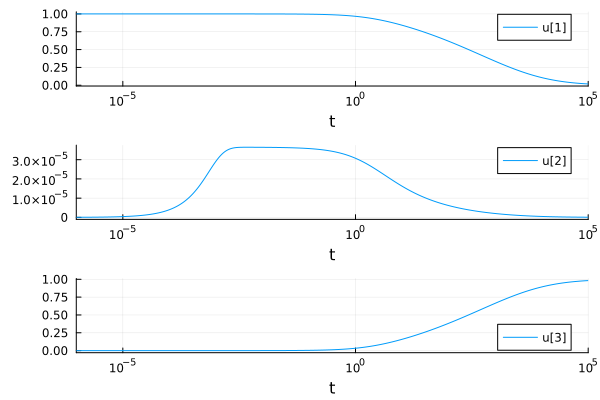

In [3]:
using DifferentialEquations, Plots

function rober!(du, u, p, t)
    y₁, y₂, y₃ = u
    k₁, k₂, k₃ = p
    du[1] = -k₁ * y₁ + k₃ * y₂ * y₃
    du[2] = k₁ * y₁ - k₃ * y₂ * y₃ - k₂ * y₂^2
    du[3] = y₁ + y₂ + y₃ - 1
    nothing
end

M = [1 0 0
     0 1 0
     0 0 0]
f = ODEFunction(rober!, mass_matrix = M)
prob_mm = ODEProblem(f, [1.0, 0.0, 0.0], (0.0, 1e5), (0.04, 3e7, 1e4))
sol = solve(prob_mm, Rodas5(), reltol = 1e-8, abstol = 1e-8)

plot(sol, xscale = :log10, tspan = (1e-6, 1e5), layout = (3, 1))

> If the mass matrix is singular, i.e., the system is a DAE, then you need to make sure you choose a solver that is compatible with DAEs

## Implicitly-Defined DAEs <a id="implicitly_defined_DAEs" />

In this example, we will solve the Robertson equation in its implicit form:

```math
F \left( \frac{du}{dt},u,p,t \right) = 0
```

This equation is a DAE of the form:

```math
\begin{aligned}
\frac{du}{dt} &= f(u,p,t) \\
 0 &= g(u,p,t) \\
 \end{aligned}
```

which is also known as a constrained differential equation, where `g` is the constraint
equation. The Robertson model can be written in the form:

```math
\begin{aligned}
\frac{dy_1}{dt} &= -0.04y₁ + 10^4 y_2 y_3 \\
\frac{dy_2}{dt} &= 0.04 y_1 - 10^4 y_2 y_3 - 3*10^7 y_{2}^2 \\
1 &=  y_{1} + y_{2} + y_{3} \\
\end{aligned}
```

with initial conditions ``y_1(0) = 1``, ``y_2(0) = 0``, ``y_3(0) = 0``,
``dy_1 = - 0.04``, ``dy_2 = 0.04``, and ``dy_3 = 0.0``.

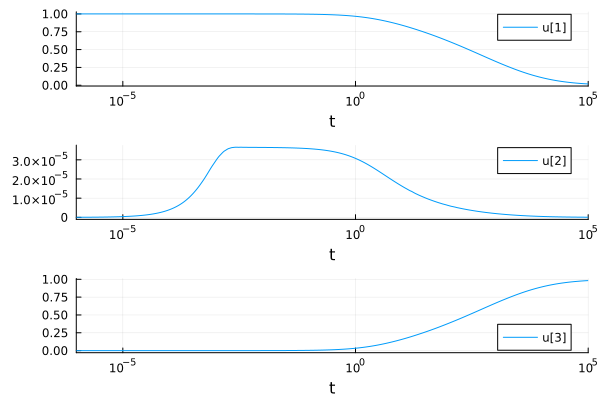

In [5]:
function f2(out, du, u, p, t)
    out[1] = -0.04u[1] + 1e4 * u[2] * u[3] - du[1]
    out[2] = +0.04u[1] - 3e7 * u[2]^2 - 1e4 * u[2] * u[3] - du[2]
    out[3] = u[1] + u[2] + u[3] - 1.0
end

u₀ = [1.0, 0, 0]
du₀ = [-0.04, 0.04, 0.0]
tspan = (0.0, 100000.0)

differential_vars = [true, true, false]
prob = DAEProblem(f2, du₀, u₀, tspan, differential_vars = differential_vars)

using Sundials
sol = solve(prob, IDA())

plot(sol, xscale = :log10, tspan = (1e-6, 1e5), layout = (3, 1))